In [3]:
import pandas as pd
import numpy as np

# Load datasets
prop_2016 = pd.read_csv("properties_2016.csv", low_memory=False)
prop_2017 = pd.read_csv("properties_2017.csv", low_memory=False)
train_2016 = pd.read_csv("train_2016.csv")
train_2017 = pd.read_csv("train_2017.csv")

# Merge training sets with properties
df_2016 = train_2016.merge(prop_2016, how='left', on='parcelid')
df_2017 = train_2017.merge(prop_2017, how='left', on='parcelid')

# Add transaction year column
df_2016['transactiondate'] = pd.to_datetime(df_2016['transactiondate'])
df_2017['transactiondate'] = pd.to_datetime(df_2017['transactiondate'])
df_2016['year'] = 2016
df_2017['year'] = 2017

# Combine for joint analysis
df_all = pd.concat([df_2016, df_2017], axis=0)


In [4]:
print(len(df_all))

167888


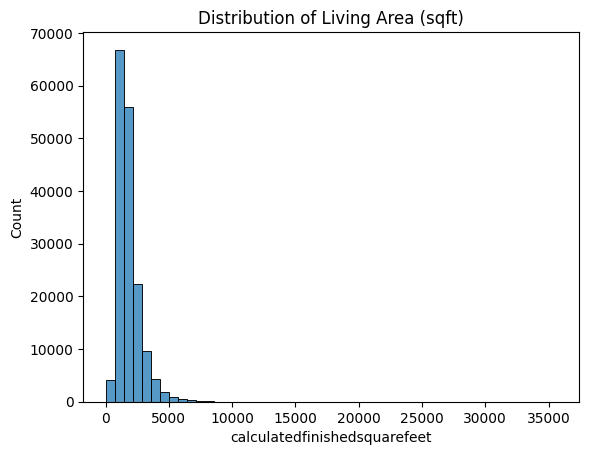

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(df_all['calculatedfinishedsquarefeet'].dropna(), bins=50)
plt.title("Distribution of Living Area (sqft)")
plt.show()

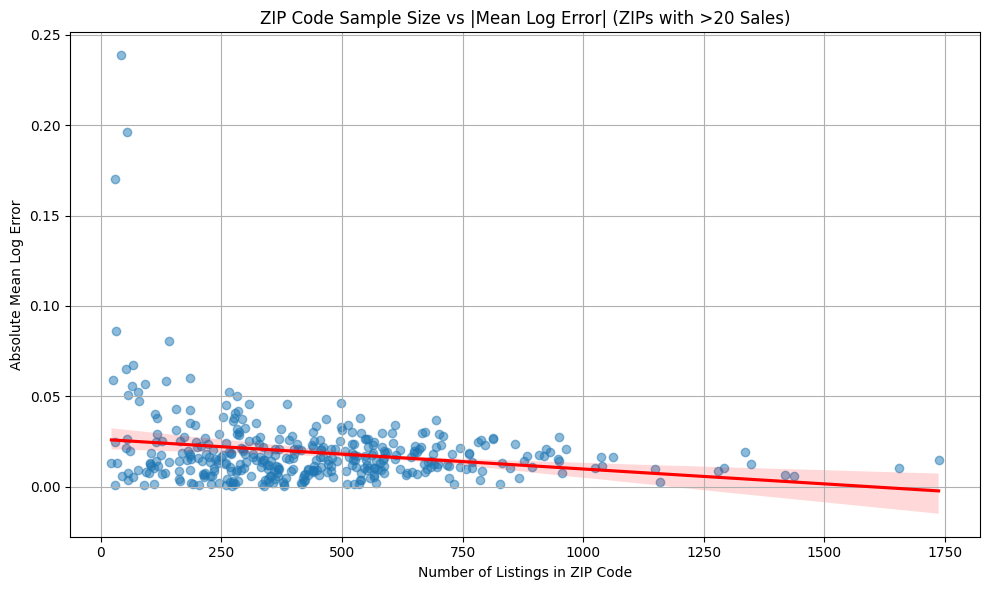

In [36]:
# Group by ZIP code and compute count and mean absolute log error
zip_stats = df_all.groupby('regionidzip')['logerror'].agg(['mean', 'count']).reset_index()
zip_stats['abs_mean'] = zip_stats['mean'].abs()
zip_stats = zip_stats[zip_stats['count'] > 20]  # Filter out ZIPs with small counts

# Plot count vs absolute mean log error with trend line
plt.figure(figsize=(10, 6))
sns.regplot(data=zip_stats, x='count', y='abs_mean', scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title("ZIP Code Sample Size vs |Mean Log Error| (ZIPs with >20 Sales)")
plt.xlabel("Number of Listings in ZIP Code")
plt.ylabel("Absolute Mean Log Error")
plt.grid(True)
plt.tight_layout()
plt.show()




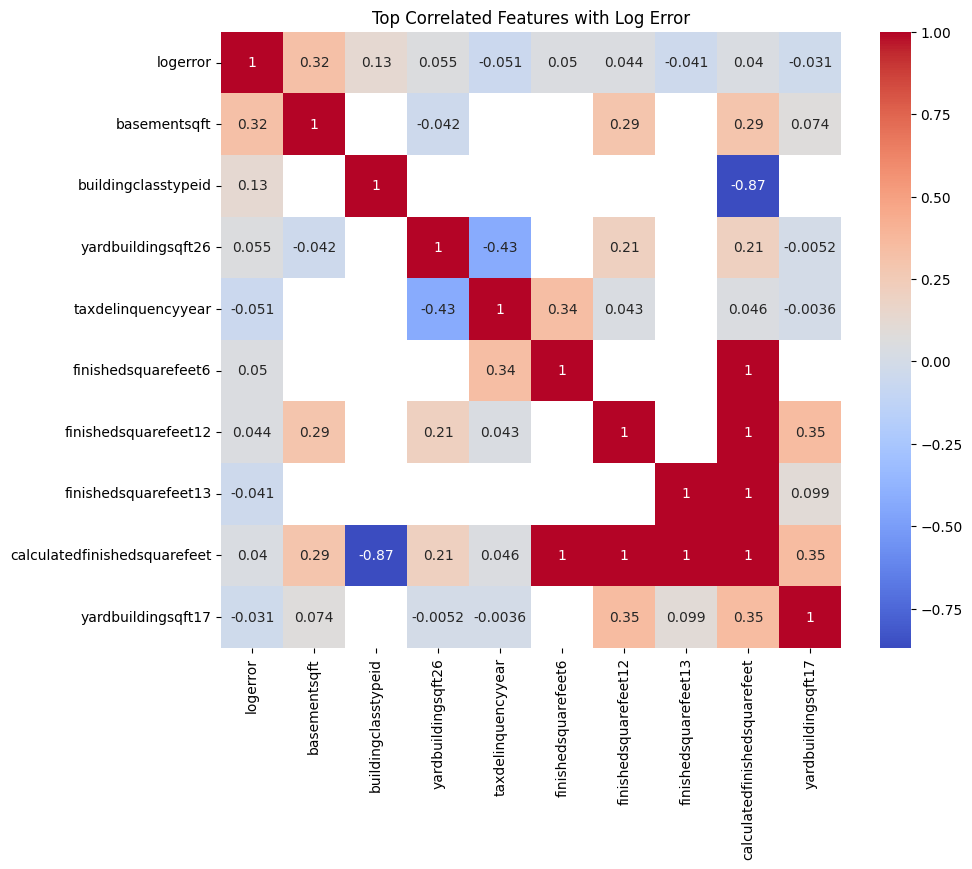

In [7]:
numeric_feats = df_all.select_dtypes(include=[np.number]).drop(columns=['parcelid', 'year'])
corr = numeric_feats.corr()
top_corr = corr['logerror'].abs().sort_values(ascending=False).head(10).index

plt.figure(figsize=(10, 8))
sns.heatmap(df_all[top_corr].corr(), annot=True, cmap='coolwarm')
plt.title("Top Correlated Features with Log Error")
plt.show()


Q1: How does the living area (sqft) affect property value? Is there a linear relationship?


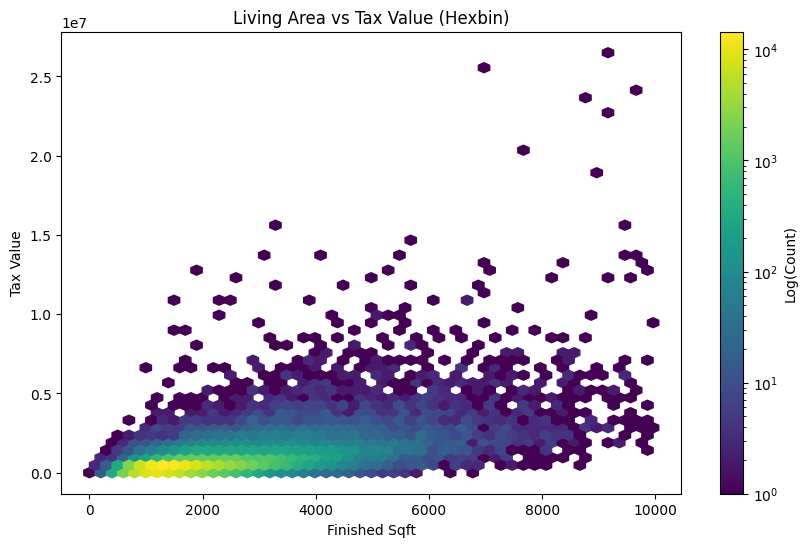

In [33]:
plot_data = df_all[df_all['calculatedfinishedsquarefeet'] < 10000].copy()
plot_data = plot_data[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']].dropna().reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.hexbin(
    x=plot_data['calculatedfinishedsquarefeet'],
    y=plot_data['taxvaluedollarcnt'],
    gridsize=50,
    cmap='viridis',
    bins='log'
)
plt.colorbar(label='Log(Count)')
plt.title("Living Area vs Tax Value (Hexbin)")
plt.xlabel("Finished Sqft")
plt.ylabel("Tax Value")
plt.show()



Q2: Do more bathrooms correlate with higher values?

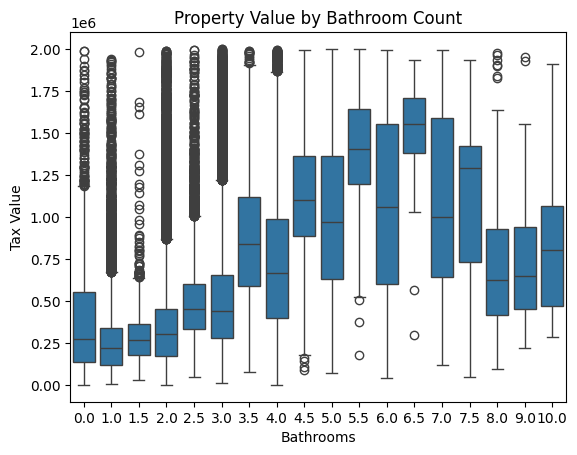

In [28]:
plot_data = df_all[['bathroomcnt', 'taxvaluedollarcnt']].dropna().copy()
plot_data = plot_data[(plot_data['bathroomcnt'] <= 10) & (plot_data['taxvaluedollarcnt'] < 2e6)]

sns.boxplot(data=plot_data, x='bathroomcnt', y='taxvaluedollarcnt')
plt.title("Property Value by Bathroom Count")
plt.xlabel("Bathrooms")
plt.ylabel("Tax Value")
plt.show()


 Q3: How does home age affect value or price per square foot?

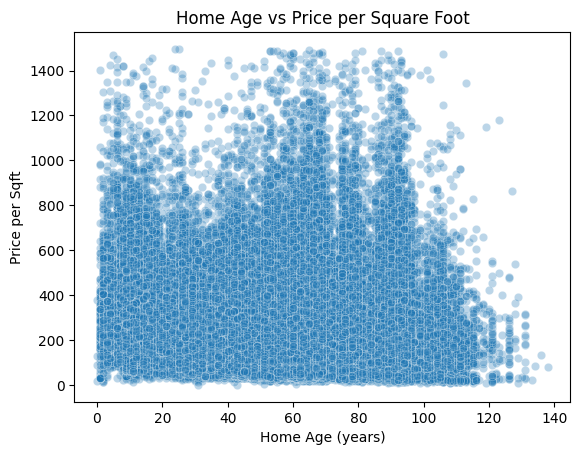

In [29]:
plot_data = df_all[['yearbuilt', 'taxvaluedollarcnt', 'calculatedfinishedsquarefeet']].dropna().copy()
plot_data['home_age'] = 2016 - plot_data['yearbuilt']
plot_data['price_per_sqft'] = plot_data['taxvaluedollarcnt'] / plot_data['calculatedfinishedsquarefeet']
plot_data = plot_data[(plot_data['home_age'] < 150) & (plot_data['price_per_sqft'] < 1500)]

sns.scatterplot(data=plot_data, x='home_age', y='price_per_sqft', alpha=0.3)
plt.title("Home Age vs Price per Square Foot")
plt.xlabel("Home Age (years)")
plt.ylabel("Price per Sqft")
plt.show()


Q4: Which ZIP codes have the highest average property values?

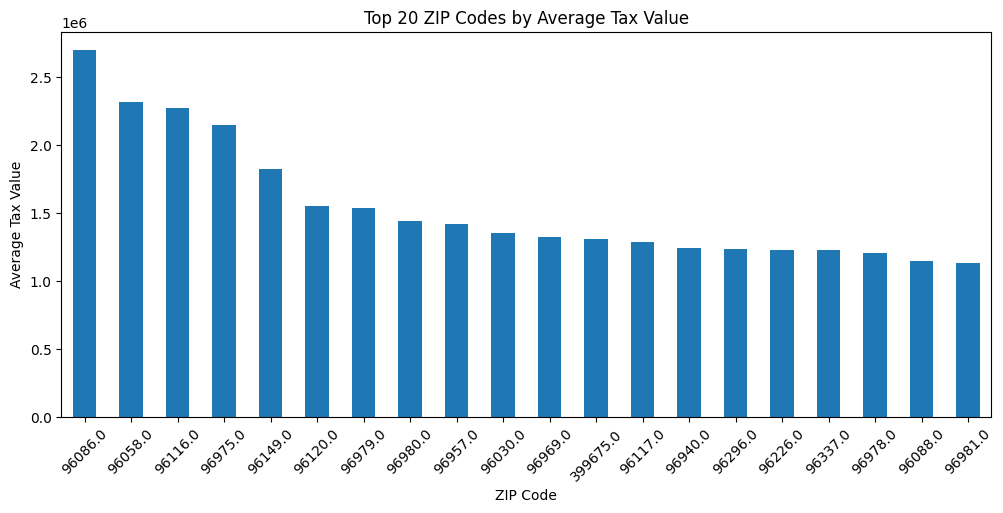

In [30]:
plot_data = df_all[['regionidzip', 'taxvaluedollarcnt']].dropna().copy()
zip_means = plot_data.groupby('regionidzip')['taxvaluedollarcnt'].mean().sort_values(ascending=False).head(20)

zip_means.plot(kind='bar', figsize=(12, 5))
plt.title("Top 20 ZIP Codes by Average Tax Value")
plt.ylabel("Average Tax Value")
plt.xlabel("ZIP Code")
plt.xticks(rotation=45)
plt.show()


Q5: How does bedroom count relate to value?

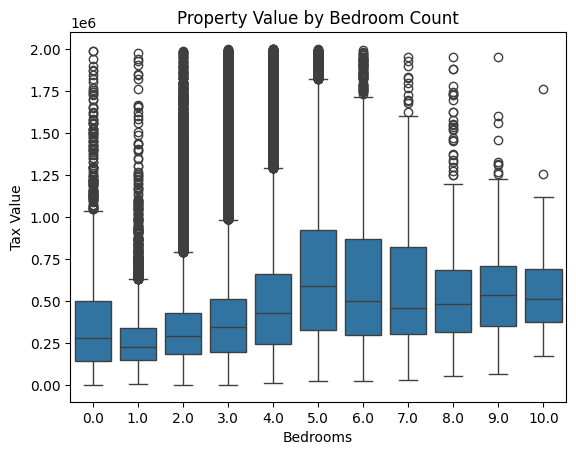

In [31]:
plot_data = df_all[['bedroomcnt', 'taxvaluedollarcnt']].dropna().copy()
plot_data = plot_data[(plot_data['bedroomcnt'] <= 10) & (plot_data['taxvaluedollarcnt'] < 2e6)]

sns.boxplot(data=plot_data, x='bedroomcnt', y='taxvaluedollarcnt')
plt.title("Property Value by Bedroom Count")
plt.xlabel("Bedrooms")
plt.ylabel("Tax Value")
plt.show()


Q6: What’s the distribution of prediction errors (logerror) and where are they largest?

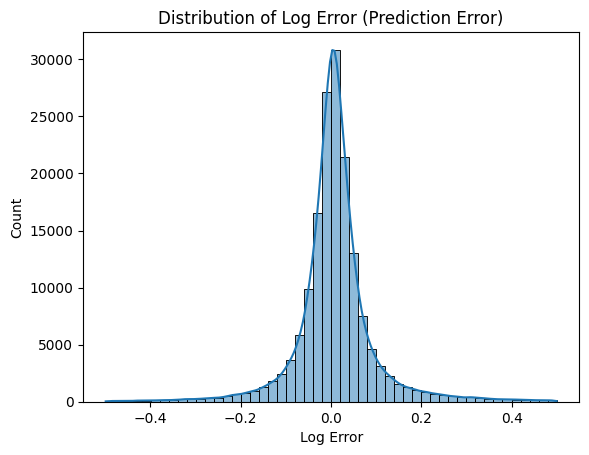

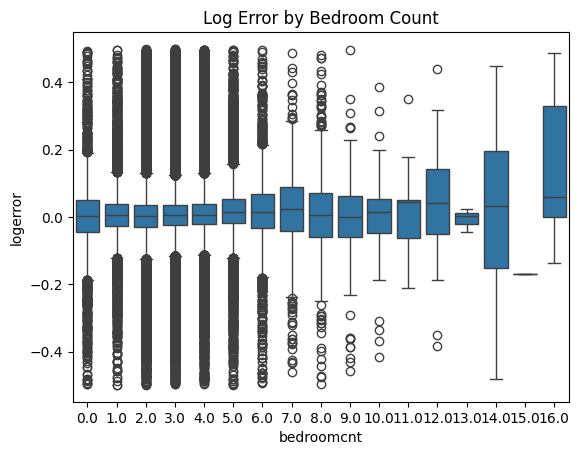

In [32]:
plot_data = df_all[['logerror', 'bedroomcnt']].dropna().copy()
plot_data = plot_data[plot_data['logerror'].between(-0.5, 0.5)]

sns.histplot(data=plot_data, x='logerror', bins=50, kde=True)
plt.title("Distribution of Log Error (Prediction Error)")
plt.xlabel("Log Error")
plt.ylabel("Count")
plt.show()

sns.boxplot(data=plot_data, x='bedroomcnt', y='logerror')
plt.title("Log Error by Bedroom Count")
plt.show()


Question 7: Are older homes more prone to Zestimate error?

/var/folders/t2/_ntz6m1d0nb7xqv44k89vwmw0000gn/T/ipykernel_3971/4070608808.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['home_age'] = df_all['year'] - df_all['yearbuilt']


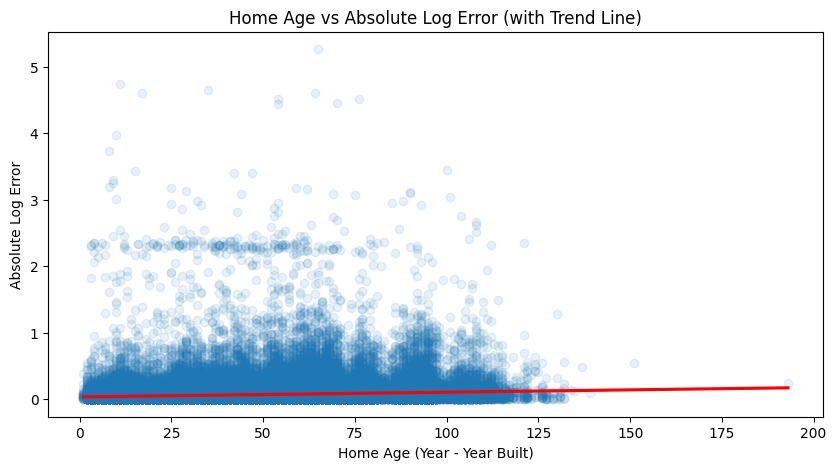

In [39]:
df_all['home_age'] = df_all['year'] - df_all['yearbuilt']
age_plot = df_all[['home_age', 'abs_logerror']].dropna()
age_plot = age_plot[age_plot['home_age'] > 0]

plt.figure(figsize=(10, 5))
sns.regplot(data=age_plot, x='home_age', y='abs_logerror', scatter_kws={'alpha':0.1}, line_kws={'color': 'red'})
plt.title('Home Age vs Absolute Log Error (with Trend Line)')
plt.xlabel('Home Age (Year - Year Built)')
plt.ylabel('Absolute Log Error')
plt.show()


Insight: While individual data points are noisy, a slight positive trend indicates that older homes may be modestly more prone to error—potentially due to age-related factors not fully captured in available features. The relationship is weak and noisy—suggesting that home age alone is not a reliable predictor of error. Trend line slightly increases, but the effect size is modest.


# Question 2: Do certain ZIP codes have higher errors?

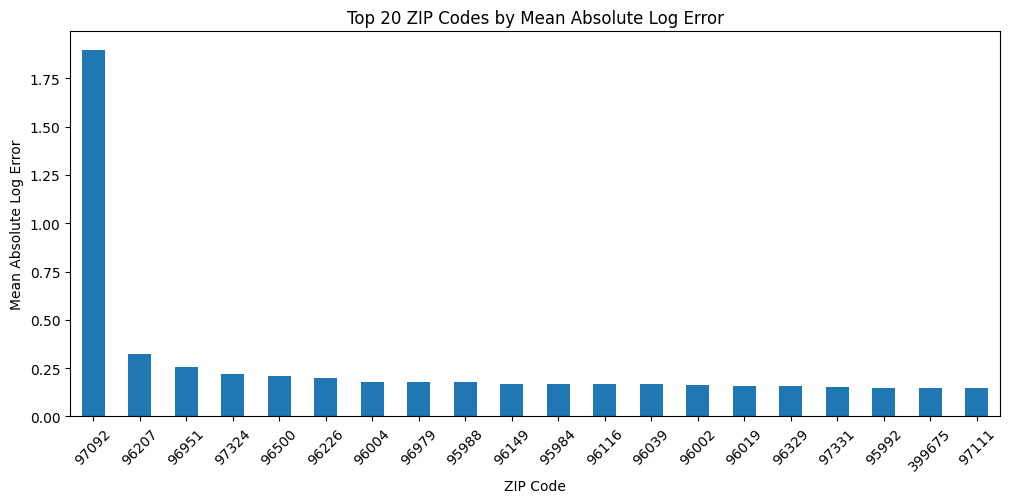

In [41]:
df_all = df_all[~df_all['regionidzip'].isna()]
df_all['regionidzip'] = df_all['regionidzip'].astype(int)

zip_errors = df_all.groupby('regionidzip')['abs_logerror'].mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 5))
zip_errors.plot(kind='bar')
plt.title('Top 20 ZIP Codes by Mean Absolute Log Error')
plt.ylabel('Mean Absolute Log Error')
plt.xlabel('ZIP Code')
plt.xticks(rotation=45)
plt.show()


In [43]:
# Count of records from ZIP 97092
zip_97092_count = df_all[df_all['regionidzip'] == 97092].shape[0]

# Total number of records
total_count = df_all.shape[0]

# Proportion of data from ZIP 97092
proportion_97092 = zip_97092_count / total_count

print(f"ZIP 97092 makes up {proportion_97092:.4%} of the dataset.")


ZIP 97092 makes up 0.0006% of the dataset.


Insight: ZIP 97092 makes up 0.0006% of the dataset, so its very high error is not a major source of bias despite appearing extreme in top error plots.

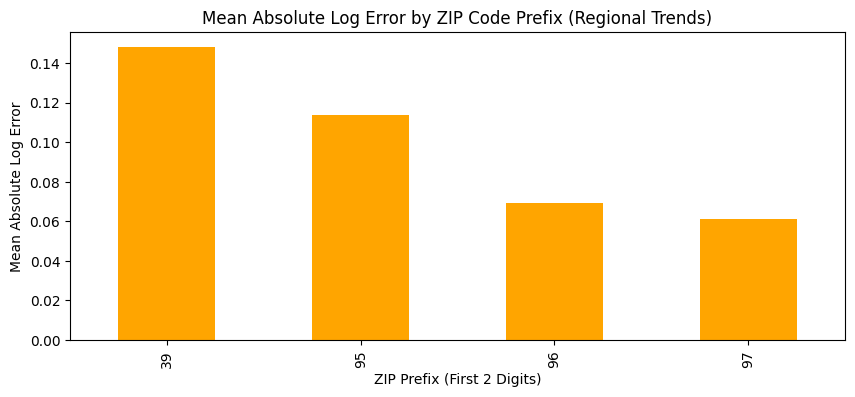

In [42]:
# Group by first 2 digits of ZIP to infer regional/state-level trends
df_all['zip_prefix'] = df_all['regionidzip'].astype(str).str[:2]
zip_prefix_errors = df_all.groupby('zip_prefix')['abs_logerror'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 4))
zip_prefix_errors.plot(kind='bar', color='orange')
plt.title('Mean Absolute Log Error by ZIP Code Prefix (Regional Trends)')
plt.xlabel('ZIP Prefix (First 2 Digits)')
plt.ylabel('Mean Absolute Log Error')
plt.show()

Insight: Some regions (ZIP prefixes) show consistently higher errors, suggesting geographic or market-specific challenges in pricing accuracy.

# Question 3: Are unusual combinations of beds/baths error-prone?

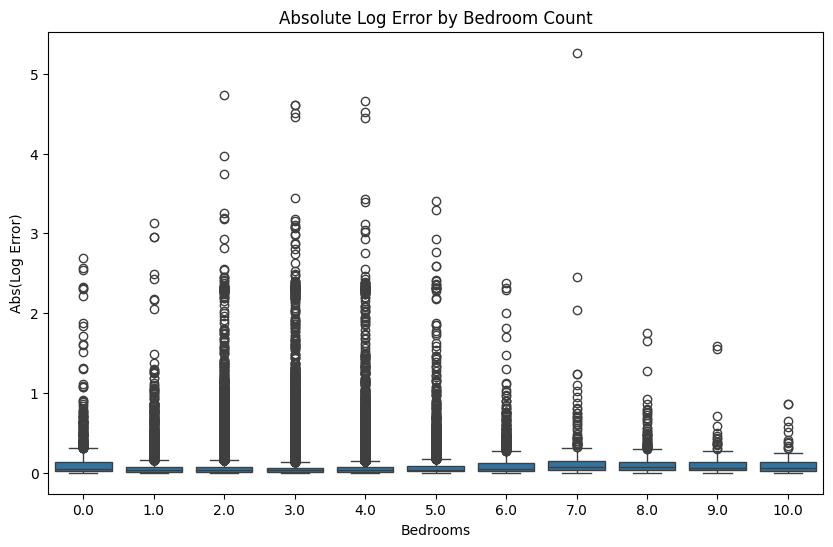

In [45]:

bb_data = df_all[(df_all['bedroomcnt'] <= 10) & (df_all['bathroomcnt'] <= 10)]

plt.figure(figsize=(10, 6))
sns.boxplot(data=bb_data, x='bedroomcnt', y='abs_logerror')
plt.title('Absolute Log Error by Bedroom Count')
plt.xlabel('Bedrooms')
plt.ylabel('Abs(Log Error)')
plt.show()

# Question 5: Are very small or large homes more error-prone?

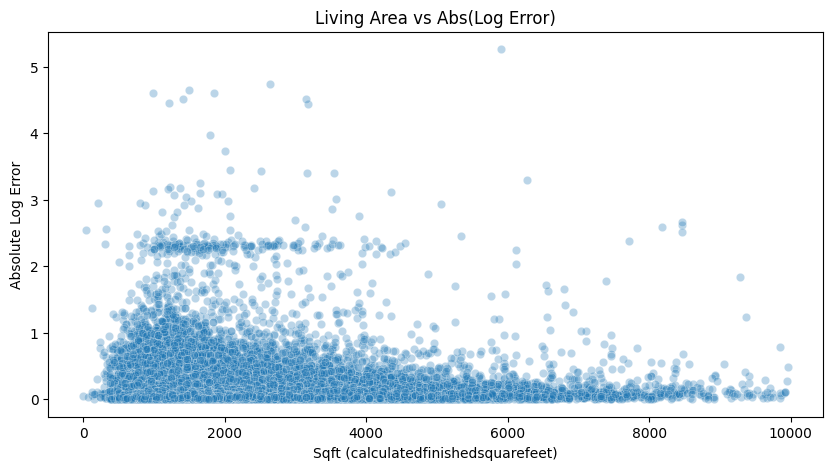

In [47]:
sf_data = df_all[df_all['calculatedfinishedsquarefeet'] < 10000][['calculatedfinishedsquarefeet', 'abs_logerror']].dropna()

plt.figure(figsize=(10, 5))
sns.scatterplot(data=sf_data, x='calculatedfinishedsquarefeet', y='abs_logerror', alpha=0.3)
plt.title('Living Area vs Abs(Log Error)')
plt.xlabel('Sqft (calculatedfinishedsquarefeet)')
plt.ylabel('Absolute Log Error')
plt.show()

Linear Regression Test MSE: 0.025750


/var/folders/t2/_ntz6m1d0nb7xqv44k89vwmw0000gn/T/ipykernel_823/3820936208.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df.head(10), x='coefficient', y='feature', palette='coolwarm')


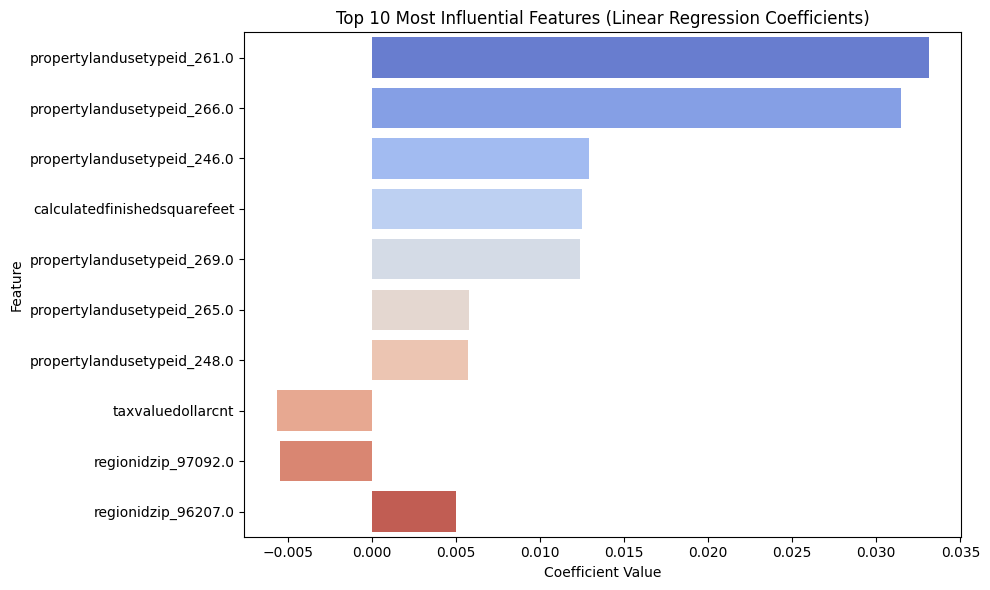

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features used in the model
features = [
    'calculatedfinishedsquarefeet', 'taxvaluedollarcnt',
    'yearbuilt', 'lotsizesquarefeet', 'regionidzip', 'propertylandusetypeid'
]

# Prepare the data
model_data = df_all[features + ['logerror']].dropna()
X = model_data[features]
y = model_data['logerror']

# One-hot encode categorical variables
X = pd.get_dummies(X, columns=['regionidzip', 'propertylandusetypeid'], drop_first=True)

# Split and scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Linear Regression model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_lr = lr.predict(X_test_scaled)
mse_lr = mean_squared_error(y_test, y_pred_lr)

print(f"Linear Regression Test MSE: {mse_lr:.6f}")


# Get feature names and coefficients
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr.coef_
}).sort_values(by='coefficient', key=abs, ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df.head(10), x='coefficient', y='feature', palette='coolwarm')
plt.title("Top 10 Most Influential Features (Linear Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [29]:
# Get coefficients and match them with feature names
coefficients = lr.coef_
feature_names = X_train.columns

# Create a DataFrame for easier inspection
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

# Take absolute value to assess importance regardless of direction
coef_df['importance'] = coef_df['coefficient'].abs()

# Sort by importance
coef_df_sorted = coef_df.sort_values(by='importance', ascending=False)

# Display top 20
print(coef_df_sorted.head(20))

                          feature  coefficient  importance
398   propertylandusetypeid_261.0     0.031751    0.031751
402   propertylandusetypeid_266.0     0.030320    0.030320
394   propertylandusetypeid_246.0     0.012334    0.012334
2    calculatedfinishedsquarefeet     0.011921    0.011921
404   propertylandusetypeid_269.0     0.011839    0.011839
3               taxvaluedollarcnt    -0.005641    0.005641
401   propertylandusetypeid_265.0     0.005562    0.005562
364           regionidzip_97092.0    -0.005461    0.005461
396   propertylandusetypeid_248.0     0.005359    0.005359
136           regionidzip_96207.0     0.005021    0.005021
395   propertylandusetypeid_247.0     0.004441    0.004441
393    propertylandusetypeid_47.0     0.003923    0.003923
247           regionidzip_96464.0     0.003750    0.003750
259           regionidzip_96488.0     0.003734    0.003734
399   propertylandusetypeid_263.0     0.003731    0.003731
130           regionidzip_96193.0     0.003359    0.0033

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Regression Modeling to Predict Log Error
features = [
    'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt',
    'yearbuilt', 'lotsizesquarefeet', 'regionidzip', 'propertylandusetypeid'
]
model_data = df_all[features + ['logerror']].dropna()
X = model_data[features]
y = model_data['logerror']

# Handle categorical variables
X = pd.get_dummies(X, columns=['regionidzip', 'propertylandusetypeid'], drop_first=True)

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_scaled, y_train)

# Evaluate
y_pred = rf.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.6f}")



Test MSE: 0.026056


In [23]:
# Get top 8 features
feature_names = X_train.columns  # original feature names before scaling
importances = rf.feature_importances_
top_8_indices = np.argsort(importances)[-8:]
top_8_features = feature_names[top_8_indices]

print("Top 8 features:")
print(top_8_features)

# Step 2: Filter X to only top 20 features
X_top8 = X[top_8_features]

# Step 3: Train-test split and scale again
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top8, y, test_size=0.2, random_state=42)
scaler_top = StandardScaler()
X_train_top_scaled = scaler_top.fit_transform(X_train_top)
X_test_top_scaled = scaler_top.transform(X_test_top)

# Step 4: Retrain and evaluate
rf_top8 = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_top8.fit(X_train_top_scaled, y_train_top)

y_pred_top = rf_top8.predict(X_test_top_scaled)
mse_top = mean_squared_error(y_test_top, y_pred_top)
print(f"Test MSE with Top 20 Features: {mse_top:.6f}")

Top 8 features:
Index(['regionidzip_97092.0', 'regionidzip_96181.0', 'bathroomcnt',
       'bedroomcnt', 'yearbuilt', 'calculatedfinishedsquarefeet',
       'taxvaluedollarcnt', 'lotsizesquarefeet'],
      dtype='object')
Test MSE with Top 20 Features: 0.025806


In [ ]:
# Generate summary statistics
summary = df_all[features].describe().T  
summary['missing_values'] = df_all[features].isnull().sum()

# Add median manually
medians = df_all[features].median()
summary['median'] = medians

# Rearrange columns 
summary = summary[['count', 'missing_values', 'mean', 'median', 'std', 'min', 'max']]

print(summary)

                                 count  missing_values           mean  \
bedroomcnt                    167854.0              34       3.041739   
bathroomcnt                   167854.0              34       2.288265   
calculatedfinishedsquarefeet  166992.0             896    1778.630246   
taxvaluedollarcnt             167852.0              36  472683.323088   
yearbuilt                     166828.0            1060    1968.569311   
lotsizesquarefeet             149446.0           18442   29510.596012   
regionidzip                   167769.0             119   96586.390722   
propertylandusetypeid         167854.0              34     261.828619   

                                median            std      min         max  
bedroomcnt                         3.0       1.149134      0.0        16.0  
bathroomcnt                        2.0       1.000835      0.0        20.0  
calculatedfinishedsquarefeet    1541.0     940.356025      2.0     35640.0  
taxvaluedollarcnt             3500

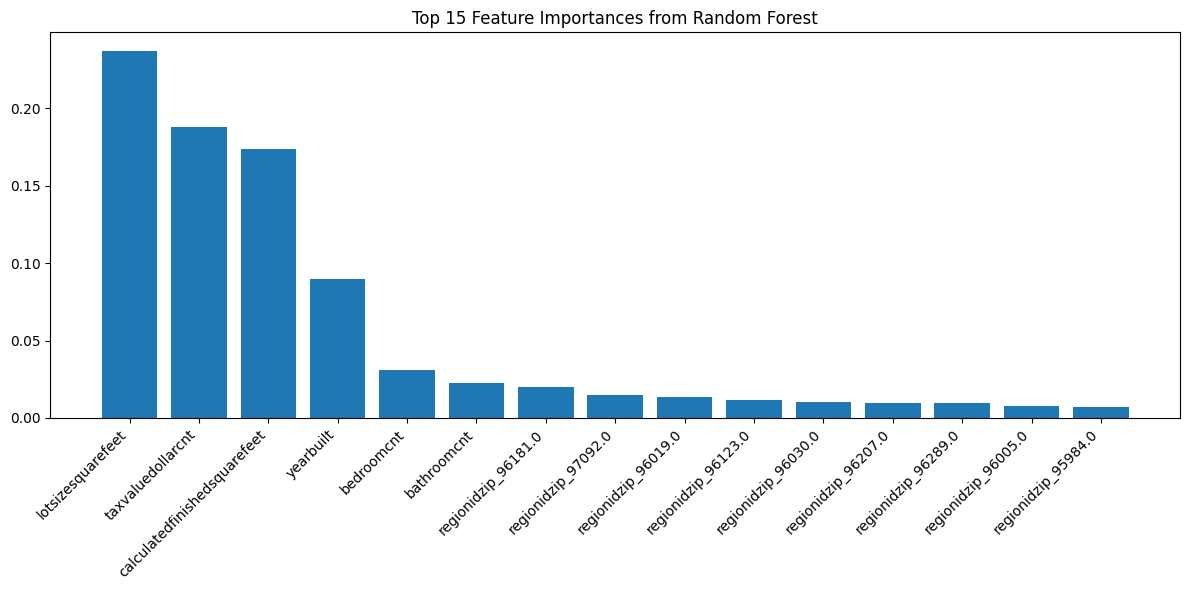

In [11]:
importances = rf.feature_importances_
features_list = X.columns
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.bar(range(15), importances[sorted_indices[:15]])
plt.xticks(range(15), features_list[sorted_indices[:15]], rotation=45, ha='right')
plt.title("Top 15 Feature Importances from Random Forest")
plt.tight_layout()
plt.show()



In [ ]:
# excluding regionidzip
features_no_zip = [
    'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',
    'taxvaluedollarcnt', 'yearbuilt', 'lotsizesquarefeet',
    'propertylandusetypeid'
]

model_data_no_zip = df_all[features_no_zip + ['logerror']].dropna()
X_no_zip = model_data_no_zip[features_no_zip]
y_no_zip = model_data_no_zip['logerror']

# One-hot encode categorical variable
X_no_zip = pd.get_dummies(X_no_zip, columns=['propertylandusetypeid'], drop_first=True)

# Train-test split
X_train_nz, X_test_nz, y_train_nz, y_test_nz = train_test_split(X_no_zip, y_no_zip, test_size=0.2, random_state=42)

# Standardize features
scaler_nz = StandardScaler()
X_train_nz_scaled = scaler_nz.fit_transform(X_train_nz)
X_test_nz_scaled = scaler_nz.transform(X_test_nz)

# Train Random Forest
rf_nz = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_nz.fit(X_train_nz_scaled, y_train_nz)

# Evaluate
y_pred_nz = rf_nz.predict(X_test_nz_scaled)
mse_nz = mean_squared_error(y_test_nz, y_pred_nz)
print(f"Test MSE without ZIP code: {mse_nz:.6f}")

Test MSE without ZIP code: 0.026972
